Tutorial on transformers for flavour tagging
=============

ML for Physics @ LIP: https://indico.lip.pt/event/1909/

Author: Inês Ochoa

## Introduction
In this tutorial we will train a transformer neural network for the task of classifying jets into b-jets, c-jets or light-jets (aka flavour tagging).

**Flavour tagging** relies on the characteristic signatures of b- (and to a lesser extend) c-hadrons in a detector, thanks to their relatively long lifetimes and leptonic decay signatures. B-hadrons, in particular, can have lifetimes of the order of 1.5 ps which means that when produced with enough transverse momentum, their average flight length will be of a few mm. This can be explored to develop techniques to identify jets that contain B-hadrons. 

The key inputs to b-tagging algorithms are the charged particle tracks reconstructed by the ATLAS or CMS trackers. Variables related to the impact parameter of the tracks can be used to discriminate between heavy flavor and light jets.

We will follow closely the example of the 'GN1' tagger, the state-of-the-art ATLAS flavour tagging algorithm documented in [ATL-PHYS-PUB-2022-027](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PUBNOTES/ATL-PHYS-PUB-2022-027/).

The GN1 architecture is illustrated in this diagram (from the ATLAS public result):


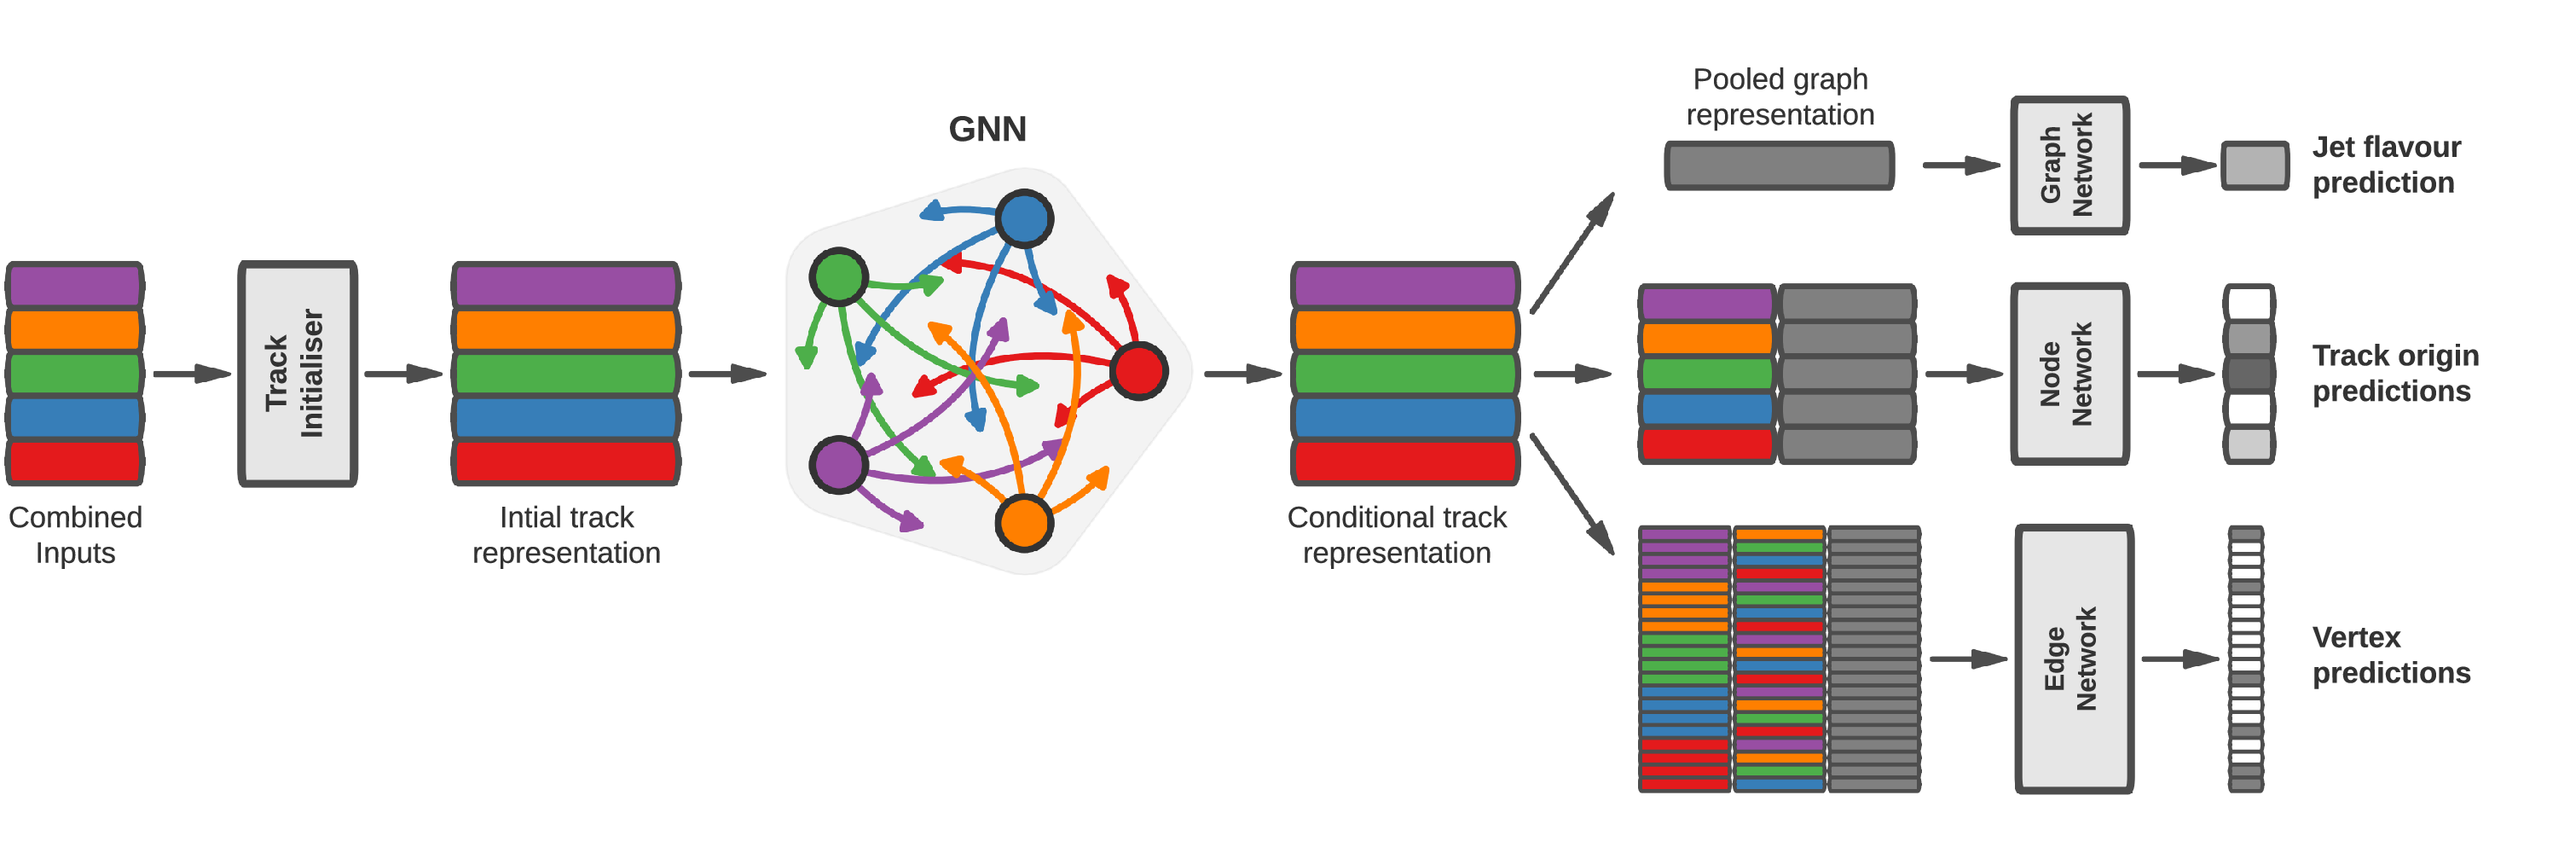

The GN1 takes jet- and track-level variables as inputs, which are then fed into a "track initialisation network" (similar to a Deep Sets model). A fully connected graph is then built connecting all tracks in the jet, with their initial representation. The output are track representations conditional on the other tracks in the jet. An additional global representation of the jet is constructed by combining the conditional track representations with a weighted sum (with attention weights learned during training). Finally, three separate fully connected feedforward neural networks are used to perform three classification objectives:
1. Jet Flavour Prediction: is the jet $b-$, $c-$ or light?
2. Track origin predictions: are the tracks from pile-up or from the primary interaction? Do they originate in the decay of the b-hadron?
3. Vertex predictions: an edge binary classification network, where each pair of tracks is classified as originating from the same or distinct vertices.

## Setting up libraries

In [ ]:
# some libraries to install:
! pip install uproot
! pip install pandas
! pip install awkward
! pip install scikit-learn
#! pip install awkward_pandas
! pip install --quiet pytorch-lightning>=1.4
! pip install matplotlib
! pip install ipywidgets

In [1]:
import os

import uproot
#import awkward_pandas
import awkward as ak
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


## The dataset

The dataset used is available publicly on Zenodo: [10.5281/zenodo.4044628
](https://zenodo.org/records/4044628). An alternative version with many more jets is available on [10.5281/zenodo.13350327
](https://zenodo.org/records/13350327).

It's a collection of b-, c- and light-jets generated in a top-pair production process at the LHC. The events undergo a simplified simulation of an ATLAS-like detector. You can find more details on the above Zenodo links.

In [ ]:
os.makedirs("ftag_dataset", exist_ok=True)

In [53]:
! ls ftag_dataset

get_dataloaders.sh  test_data.root  train_dl.pth	val_dl.pth
get_data.sh	    test_dl.pth     training_data.root	valid_data.root


In [55]:
# Download the input data by uncommenting the following lines:
#! wget https://zenodo.org/records/4044628/files/test_data.root?download=1
#! mv test_data.root?download=1 ftag_dataset/test_data.root

#! wget https://zenodo.org/records/4044628/files/training_data.root?download=1
#! mv training_data.root?download=1 ftag_dataset/training_data.root

#! wget https://zenodo.org/records/4044628/files/valid_data.root?download=1
#! mv valid_data.root?download=1 ftag_dataset/valid_data.root

In [54]:
DATAPATH="ftag_dataset/" 
! ls $DATAPATH

get_dataloaders.sh  test_data.root  train_dl.pth	val_dl.pth
get_data.sh	    test_dl.pth     training_data.root	valid_data.root


Let's focus on the test dataset for now

In [31]:
test_file = uproot.open(DATAPATH+"test_data.root")["tree"]

In [32]:
# inspect the contents
test_file.keys()

['eventnb',
 'jet_pt',
 'jet_eta',
 'jet_phi',
 'jet_M',
 'jet_flav',
 'n_trks',
 'n_vertices',
 'trk_pythia_i',
 'trk_pdg_id',
 'trk_vtx_index',
 'trk_d0',
 'trk_z0',
 'trk_phi',
 'trk_ctgtheta',
 'trk_pt',
 'trk_charge',
 'trk_eta',
 'trk_d0err',
 'trk_z0err',
 'trk_phierr',
 'trk_ctgthetaerr',
 'trk_pterr',
 'trk_prod_x',
 'trk_prod_y',
 'trk_prod_z',
 'trk_dec_x',
 'trk_dec_y',
 'trk_dec_z',
 'hadron_pdgid',
 'hadron_decx',
 'hadron_decy',
 'hadron_decz',
 'hadron_x',
 'hadron_y',
 'hadron_z',
 'true_vtx_x',
 'true_vtx_y',
 'true_vtx_z',
 'true_vtx_L3D',
 'true_vtx_ntrks',
 'nChadrons',
 'nBhadrons',
 'nCdecay',
 'nBdecay',
 'BCdistance',
 'node_idx',
 'node_pdg_id',
 'edge_start',
 'edge_end',
 'edge_dist']

Now let's select the variables we need: jet-level information (transverse momentum and pseudo-rapidity) as well as track-level information:

In [33]:
X_trkvars = ["trk_pt","trk_d0","trk_z0","trk_phi","trk_ctgtheta","trk_pterr","trk_d0err","trk_z0err","trk_phierr","trk_ctgthetaerr"]
X_jetvars = ["jet_pt","jet_eta"]
variable_names = X_trkvars + X_jetvars
nvars = len(variable_names)
print(len(variable_names), variable_names)

12 ['trk_pt', 'trk_d0', 'trk_z0', 'trk_phi', 'trk_ctgtheta', 'trk_pterr', 'trk_d0err', 'trk_z0err', 'trk_phierr', 'trk_ctgthetaerr', 'jet_pt', 'jet_eta']


In [34]:
test_x = test_file.arrays(X_trkvars,library="np")
test_jetinfo = test_file.arrays(X_jetvars,library="np")

In [7]:
test_x['trk_pt'].shape

(181182,)

In [8]:
test_jetinfo['jet_pt'].shape

(181182,)

Our labels will be the jet flavor, b-, c- or light, following the PDG ID convention for the first two:

* 5 is for b-jets
* 4 is for charm-jets
* 0 is for light jets



In [9]:
test_y = test_file.arrays(["jet_flav"],library="np")
print(test_y['jet_flav'][:5])

[5. 5. 0. 0. 4.]


Inspecting the track features for each jet, you'll notice an irregular structure: not all jets have the same number of tracks.

In [10]:
for n in range(10):
  print("Jet ",n," trk_pt =",np.round(test_x["trk_pt"][n],2))

Jet  0  trk_pt = [ 3.    0.48  5.4   0.49  0.74 15.11 22.7  13.88  6.35 27.66]
Jet  1  trk_pt = [ 2.13  0.38  3.79 24.56  0.51  5.62  4.54  2.96  2.52  6.29]
Jet  2  trk_pt = [ 3.39 51.87  0.65  3.45  3.99  0.83  1.15]
Jet  3  trk_pt = [ 1.19  8.73  2.99  1.2   4.17  1.6   4.54 19.79  1.73  1.15]
Jet  4  trk_pt = [ 4.83  3.57 10.35  2.86  2.34  3.46 12.51  3.55  6.86]
Jet  5  trk_pt = [2.27 4.93 0.69 5.25 3.76 7.42]
Jet  6  trk_pt = [ 1.22 11.33  2.99  3.36  0.89  0.98  5.44 37.82]
Jet  7  trk_pt = [0.64 6.73 6.05 4.93 0.36 1.53 3.28 5.34 1.41 5.87 2.5  7.27 1.86 2.43]
Jet  8  trk_pt = [0.39 1.25 4.63 3.52]
Jet  9  trk_pt = [2.37 2.35 1.29 4.56 1.05 3.63 8.93 5.35 6.61 4.36]


That makes sense, but it's not easy to handle.
To avoid the awkwardness of the structure, let's create a more regular array by padding all track features up to 15 tracks, for all jets:

In [2]:
def pad_features(test_x,test_jetinfo):
  """Pads all features in test_x up to 15 tracks per jet.

  Args:
    test_x: A dictionary of NumPy arrays, where each array represents a track feature.

  Returns:
    A dictionary of padded NumPy arrays.
  """
  padded_x = {}
  for feature_name, feature_values in test_x.items():
    padded_feature = []
    for trk_features in feature_values:
      padding_length = max(0, 15 - len(trk_features))
      padded_jet_features = np.pad(trk_features, (0, padding_length), mode='constant')
      padded_feature.append(padded_jet_features[:15]) # Ensure exactly 15 elements
    padded_x[feature_name] = np.array(padded_feature)

  # extra - concatenate jet inputs into each track with same shape
  num_jets = test_jetinfo["jet_pt"].shape[0]
  padded_x["jet_pt"] = np.tile(test_jetinfo["jet_pt"].reshape(num_jets, 1), (1, 15))
  padded_x["jet_eta"] = np.tile(test_jetinfo["jet_eta"].reshape(num_jets, 1), (1, 15))

  return padded_x

In [12]:
padded_test_x = pad_features(test_x,test_jetinfo)

#Verify the shape of the padded data
for feature_name, feature_values in padded_test_x.items():
  print(f"Feature: {feature_name}, Shape: {feature_values.shape}")

Feature: trk_pt, Shape: (181182, 15)
Feature: trk_d0, Shape: (181182, 15)
Feature: trk_z0, Shape: (181182, 15)
Feature: trk_phi, Shape: (181182, 15)
Feature: trk_ctgtheta, Shape: (181182, 15)
Feature: trk_pterr, Shape: (181182, 15)
Feature: trk_d0err, Shape: (181182, 15)
Feature: trk_z0err, Shape: (181182, 15)
Feature: trk_phierr, Shape: (181182, 15)
Feature: trk_ctgthetaerr, Shape: (181182, 15)
Feature: jet_pt, Shape: (181182, 15)
Feature: jet_eta, Shape: (181182, 15)


In [16]:
for n in range(5):
  print("Jet ",n," trk_pt =",np.round(padded_test_x["trk_pt"][n],2))

Jet  0  trk_pt = [ 3.    0.48  5.4   0.49  0.74 15.11 22.7  13.88  6.35 27.66  0.    0.
  0.    0.    0.  ]
Jet  1  trk_pt = [ 2.13  0.38  3.79 24.56  0.51  5.62  4.54  2.96  2.52  6.29  0.    0.
  0.    0.    0.  ]
Jet  2  trk_pt = [ 3.39 51.87  0.65  3.45  3.99  0.83  1.15  0.    0.    0.    0.    0.
  0.    0.    0.  ]
Jet  3  trk_pt = [ 1.19  8.73  2.99  1.2   4.17  1.6   4.54 19.79  1.73  1.15  0.    0.
  0.    0.    0.  ]
Jet  4  trk_pt = [ 4.83  3.57 10.35  2.86  2.34  3.46 12.51  3.55  6.86  0.    0.    0.
  0.    0.    0.  ]


Note that the last stage of the padding function also concatenates the jet variables (eta and pt) into each track, as illustrated here:

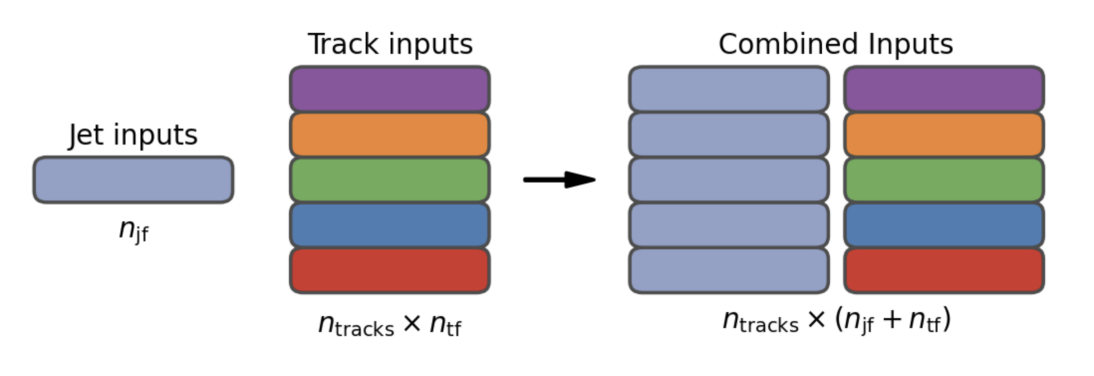

### Additional preprocessing

Let's simplify the data structure further and just deal with a numpy array directly:

In [13]:
# Turn padded_test_x into a simple 3D numpy array
X_test = np.array([padded_test_x[name] for name in variable_names])#.reshape(-1,15,nvars)
X_test = np.moveaxis(X_test, 0, -1)
Y_test = np.array(test_y['jet_flav']).reshape(-1)

In [14]:
print(X_test.shape)
print(Y_test.shape)

(181182, 15, 12)
(181182,)


It's useful to split in jet flavour at this point:

In [15]:
X_test_b = X_test[Y_test==5]
X_test_c = X_test[Y_test==4]
X_test_u = X_test[Y_test==0]
print("b-jet array -> ", X_test_b.shape)
print("c-jet array -> ", X_test_c.shape)
print("u-jet array -> ", X_test_u.shape)

b-jet array ->  (60282, 15, 12)
c-jet array ->  (60416, 15, 12)
u-jet array ->  (60484, 15, 12)


So the arrays are shaped as number of jets x number of tracks (15) x number of variables (12) (or features)

### Inspecting the features

#### Jet variables

Text(0.5, 0, 'jet pseudo-rapidity')

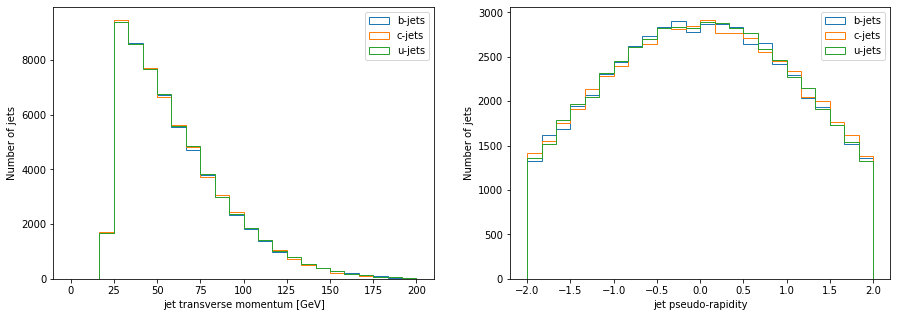

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.hist(np.ravel(X_test_b[:,0,variable_names.index("jet_pt")]),bins=np.linspace(0,200,25),histtype="step",label="b-jets")
ax1.hist(np.ravel(X_test_c[:,0,variable_names.index("jet_pt")]),bins=np.linspace(0,200,25),histtype="step",label="c-jets")
ax1.hist(np.ravel(X_test_u[:,0,variable_names.index("jet_pt")]),bins=np.linspace(0,200,25),histtype="step",label="u-jets")
ax1.set_ylabel("Number of jets")
ax1.set_xlabel("jet transverse momentum [GeV]")
ax1.legend()
ax2.hist(np.ravel(X_test_b[:,0,variable_names.index("jet_eta")]),bins=np.linspace(-2,2,25),histtype="step",label="b-jets")
ax2.hist(np.ravel(X_test_c[:,0,variable_names.index("jet_eta")]),bins=np.linspace(-2,2,25),histtype="step",label="c-jets")
ax2.hist(np.ravel(X_test_u[:,0,variable_names.index("jet_eta")]),bins=np.linspace(-2,2,25),histtype="step",label="u-jets")
ax2.legend()
ax2.set_ylabel("Number of jets")
ax2.set_xlabel("jet pseudo-rapidity")

Note that all populations of jets (b-,c- and light-jets) have identical distributions of jet transverse momentum and pseudo-rapidity. That's on purpose: the dataset has been downsampled such that these features (jet $p_T$ and $\eta$), which will be naturally different for the different classes in $t\bar{t}$ events, are not exploited by the neural network for discriminating between classes.

#### Track variables

In [17]:
# define ranges
vars_to_plot = {
  "trk_pt": np.linspace(0,100,100),
  "trk_d0": np.linspace(-5,5,100),
  "trk_z0": np.linspace(-5,5,100),
  "trk_phi": np.linspace(-5,5,100),
  "trk_ctgtheta": np.linspace(-5,5,100),
}

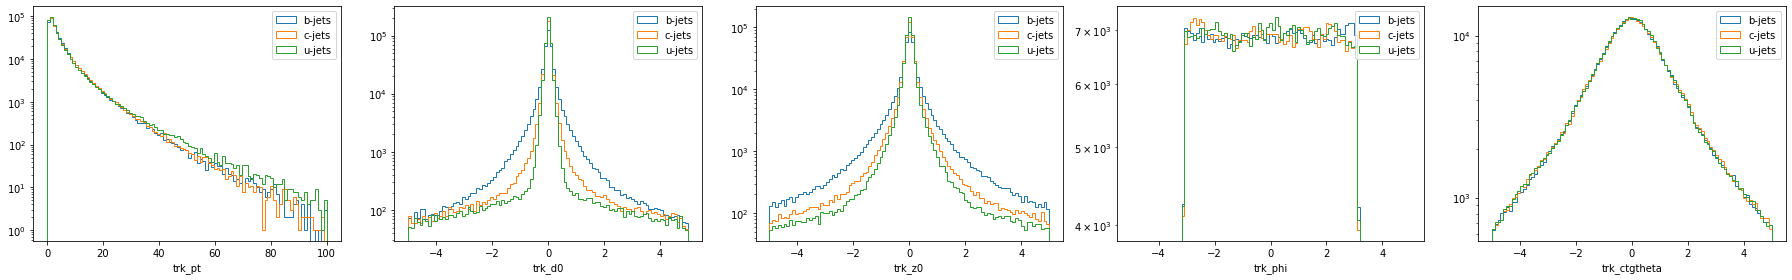

In [18]:
fig, axes = plt.subplots(1,len(vars_to_plot),figsize=(25,4))
for i,var_name in enumerate(vars_to_plot.keys()):

  # Here it's useful to define a mask so that the padded values don't show up in the histograms:
  mask_b = X_test_b[:,:,variable_names.index("trk_pt")]==0
  mask_c = X_test_c[:,:,variable_names.index("trk_pt")]==0
  mask_u = X_test_u[:,:,variable_names.index("trk_pt")]==0

  axes[i].hist(np.ravel(X_test_b[:,:,variable_names.index(var_name)][~mask_b]),bins=vars_to_plot[var_name],histtype="step",label="b-jets")
  axes[i].hist(np.ravel(X_test_c[:,:,variable_names.index(var_name)][~mask_c]),bins=vars_to_plot[var_name],histtype="step",label="c-jets")
  axes[i].hist(np.ravel(X_test_u[:,:,variable_names.index(var_name)][~mask_u]),bins=vars_to_plot[var_name],histtype="step",label="u-jets")
  axes[i].set_xlabel(var_name)
  axes[i].set_yscale("log")
  axes[i].legend()
fig.tight_layout()

It's very clear that the track's transverse and longitdunal impact parameters, $d_0$ and $z_0$, have a lot of discriminating power!

## All datasets

Now let's do the same for train and validation datasets. Let's wrap it into a function...

In [35]:
def prepare_datasets(filepath):
  file_data = uproot.open(filepath)["tree"]
  trk_x = file_data.arrays(X_trkvars,library="np")
  jet_x = file_data.arrays(X_jetvars,library="np")
  y = file_data.arrays(["jet_flav"],library="np")

  # pad the data
  padded_x = pad_features(trk_x,jet_x)

  #Verify the shape of the padded data
  for feature_name, feature_values in padded_x.items():
    print(f"Feature: {feature_name}, Shape: {feature_values.shape}")

  # Turn padded_test_x into a simple 3D numpy array
  X = np.array([padded_x[name] for name in variable_names])
  X = np.moveaxis(X, 0, -1)

  #if std==True: 
  #  for var in range(X.shape[2]):
  #    X[:,:,var] = std[var].transform(X[:,:,var])
  
  Y = np.array(y['jet_flav']).reshape(-1)
  # Now let's redefine class 5 as 2, and class 4 as 1
  # This makes our life easier later on when using one-hot encoding
  Y[Y==5] = 2
  Y[Y==4] = 1

  X_b = X[Y==2]
  X_c = X[Y==1]
  X_u = X[Y==0]
  print("\n")
  print("Number of b-jets = ", X_b.shape[0])
  print("Number of c-jets = ", X_c.shape[0])
  print("Number of u-jets = ", X_u.shape[0])
  print("\n Done. \n")

  return torch.tensor(X, dtype=torch.double), torch.tensor(Y, dtype=torch.long)


In [36]:
# Redefine some variables in case you're starting here:
X_trkvars = ["trk_pt","trk_d0","trk_z0","trk_phi","trk_ctgtheta","trk_pterr","trk_d0err","trk_z0err","trk_phierr","trk_ctgthetaerr"]
X_jetvars = ["jet_pt","jet_eta"]
variable_names = X_trkvars + X_jetvars
nvars = len(variable_names)
print(len(variable_names), variable_names)

# (go up and define the pad_features function if you haven't yet)

12 ['trk_pt', 'trk_d0', 'trk_z0', 'trk_phi', 'trk_ctgtheta', 'trk_pterr', 'trk_d0err', 'trk_z0err', 'trk_phierr', 'trk_ctgthetaerr', 'jet_pt', 'jet_eta']


In [56]:
# Start with the training dataset # This can take a couple of minutes...
X_train, Y_train = prepare_datasets(DATAPATH+"training_data.root") 

Feature: trk_pt, Shape: (543544, 15)
Feature: trk_d0, Shape: (543544, 15)
Feature: trk_z0, Shape: (543544, 15)
Feature: trk_phi, Shape: (543544, 15)
Feature: trk_ctgtheta, Shape: (543544, 15)
Feature: trk_pterr, Shape: (543544, 15)
Feature: trk_d0err, Shape: (543544, 15)
Feature: trk_z0err, Shape: (543544, 15)
Feature: trk_phierr, Shape: (543544, 15)
Feature: trk_ctgthetaerr, Shape: (543544, 15)
Feature: jet_pt, Shape: (543544, 15)
Feature: jet_eta, Shape: (543544, 15)


Number of b-jets =  181557
Number of c-jets =  180968
Number of u-jets =  181019

 Done. 



In [37]:
X_val, Y_val = prepare_datasets(DATAPATH+"valid_data.root")
X_test, Y_test = prepare_datasets(DATAPATH+"test_data.root")

Feature: trk_pt, Shape: (181182, 15)
Feature: trk_d0, Shape: (181182, 15)
Feature: trk_z0, Shape: (181182, 15)
Feature: trk_phi, Shape: (181182, 15)
Feature: trk_ctgtheta, Shape: (181182, 15)
Feature: trk_pterr, Shape: (181182, 15)
Feature: trk_d0err, Shape: (181182, 15)
Feature: trk_z0err, Shape: (181182, 15)
Feature: trk_phierr, Shape: (181182, 15)
Feature: trk_ctgthetaerr, Shape: (181182, 15)
Feature: jet_pt, Shape: (181182, 15)
Feature: jet_eta, Shape: (181182, 15)


Number of b-jets =  60282
Number of c-jets =  60416
Number of u-jets =  60484

 Done. 



### Creating the dataloaders

Dataloaders are an essential tool to deal with batching, shuffling, memory accessing, etc. 

In [14]:
class customDataset(data.Dataset): # Characterizes a dataset for PyTorch
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x,y

In [62]:
batch_size = 2048
train_loader = data.DataLoader(customDataset(data=X_train,labels=Y_train), batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True,num_workers=4)
val_loader   = data.DataLoader(customDataset(data=X_val,labels=Y_val), batch_size=batch_size,num_workers=4)
test_loader  = data.DataLoader(customDataset(data=X_test,labels=Y_test), batch_size=batch_size)

In [63]:
inp_data, labels = train_loader.dataset[1]
print("Labels:    ", labels)
print("Input data:", inp_data)


Labels:     tensor(0)
Input data: tensor([[ 8.9589e+00, -2.5658e-03,  1.9012e-02,  1.7342e+00, -5.4253e-01,
          8.3467e-02,  2.8201e-02,  3.8343e-02,  4.9536e-04,  6.4912e-04,
          9.2491e+01, -4.8874e-01],
        [ 3.4434e+00,  2.5390e-02,  3.2763e-03,  1.8145e+00, -5.4598e-01,
          3.6479e-02,  7.0954e-02,  8.7916e-02,  1.5363e-03,  1.6528e-03,
          9.2491e+01, -4.8874e-01],
        [ 1.4571e+01, -1.3045e-02,  4.1471e-02,  1.6474e+00, -4.9290e-01,
          1.5658e-01,  1.9539e-02,  2.9899e-02,  3.0771e-04,  4.9488e-04,
          9.2491e+01, -4.8874e-01],
        [ 8.5900e+00, -5.1806e-04, -1.5946e-02,  1.7085e+00, -5.0521e-01,
          7.8513e-02,  3.1125e-02,  4.1110e-02,  5.8702e-04,  6.9640e-04,
          9.2491e+01, -4.8874e-01],
        [ 5.6821e-01,  1.2394e-01,  1.2634e-01,  1.3139e+00, -6.3646e-01,
          6.1779e-03,  9.0000e-02,  1.2000e-01,  2.0000e-03,  2.2000e-03,
          9.2491e+01, -4.8874e-01],
        [ 6.4787e+00,  5.2156e-02,  4.1381e-02

The iterating through the dataloader gives us batches of 2048 jets, each with the familiar 15x12 structure:

In [65]:
for i,d in enumerate(test_loader):
  print(i,d[0].shape,d[1].shape)
  if i > 1: break

0 torch.Size([2048, 15, 12]) torch.Size([2048])
1 torch.Size([2048, 15, 12]) torch.Size([2048])
2 torch.Size([2048, 15, 12]) torch.Size([2048])


[Optional] save for later

In [66]:
torch.save(train_loader,"train_dl.pth")
torch.save(test_loader,"test_dl.pth")
torch.save(val_loader,"val_dl.pth")

### Pick up from here if starting with pre-existing dataloaders

[Optional] load previously saved loaders. Download them first, by running the ./get_dataloaders.sh script or uncommenting the following lines.

(don't forget to define the customDataset class above)

In [56]:
#! wget https://cernbox.cern.ch/s/URJeVkP0lndI7lg/download -O val_dl.pth
#! wget https://cernbox.cern.ch/s/ivafCy8wbv3Ozhk/download -O test_dl.pth
#! wget https://cernbox.cern.ch/s/zclKISp42H4kJIX/download -O train_dl.pth

In [12]:
! ls $DATAPATH

get_data.sh	test_dl.pth   training_data.root  valid_data.root
test_data.root	train_dl.pth  val_dl.pth


In [15]:
train_loader = torch.load(DATAPATH+"train_dl.pth")
test_loader = torch.load(DATAPATH+"test_dl.pth")
val_loader = torch.load(DATAPATH+"val_dl.pth")

## The Transformer Model

The introductory material on Transformers follows closely the [excellent tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/index.html) by Phillip Lippe, UvA.

The Transformer architecture was proposed in the [Attention is All You need](https://arxiv.org/abs/1706.03762) paper for addressing a language translation task without the need for recurrent or convolutional algorithms, which are costly. Instead, the Transformer is based solely on attention mechanisms. An attention mechanism is used to relate different elements in a set.

A transformer layer comprises two modules: an attention mechanism and a fully connected neural network.

### Attention mechanism

When taking in a set of elements as inputs to a neural network training (in this case, tracks in a jet), we want to combine their information in a meaningful way in order to accomplish a given task. The **attention** mechanism can be thought of as a method to dynamically determine how much each element should be considered, depending on their value. Or in other words: based on some query, we need to decide how much to attend to each element.

The components of an attention mechanism are:
* Query: a vector that encodes the information being searched for.
* Keys: vectors that encode references for that information.
* Values: another vector that matches candidates for the queries.

These components are obtained through linear trnasformations of the input. The queries and the keys are combined to produce affinity scores, which determine the weights assigned to the values. When the queries, keys and values correspond to the same inputs, we're assuming a specific type of attention mechanism, *self-attention*, which is our focus for this tutorial. Self-attention is implemented via "scaled dot product attention", formulated mathematically as:

$\text{Attention}(Q,K,V)=\text{softmax} (\frac{QK^T}{\sqrt{d_k}})V$


Dot product attention takes as input the queries $Q\in \mathbb{R}^{N\times d_k}$, keys $K\in \mathbb{R}^{N\times d_k}$ and values $V \in \mathbb{R}^{N\times d_v}$, where $N$ is the sequence length (here, number of tracks) and $d_k,d_v$ are hidden dimensionalities defined in our model.

The attention mechanism quantifies the similarity of the query and key, via their dot product. The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $N\times N$. A softmax activation is then applied to these logits, and the result is multiplied by the value vector to obtain a weighted mean.

Here's a practical example from the UaV tutorial:

In [84]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [97]:
seq_len, d_k = 3, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Global seed set to 42


Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


*Multi-head* attention is employed when a single weighted average (or attention head) isn't enough. In that case, running attention with multiple heads basically means running attention on multiple $q,k,v$ triplets for the same features. In each head, the keys, the values, and the queries are linearly projected before applying the scaled dot-product attention. The final results for all heads can be concatenated and combined with some weights.

The other module included in a transformer layer is a fully connected NN. It corresponds to an MLP formed by two layers divided by a ReLU activation. Furthermore, skip connections are introduced around both the attention and the fully connected NN, which adds the input of each step to its output. The skip connection is succeeded by a normalisation layer. 

Note that an important aspect of transformers is that they are permutation-equivariant with respect to its inputs, formally defined as:

$F (PX) = P F (X)$,

where $P$ is a permutation matrix and $F$ is a function acting on some input $X$.


That makes it particularly suitable to act on sets rather than on sequences. That is perfect for a flavour tagging where tracks have no inherent order! 

## Putting it all together

This is the transformer encoder:

In [16]:
class TransformerEncoder(nn.Module):
    """ Transformer Encoder used for track data.

    Encoder runs tracks through a few dense layers and then a variable input number of self
    attention layers mixed with denser layers and normalization.

    Attributes: 
        input_dim - Dimensionality of the input
        embed_dim - Dimensionality of the hidden layers
        num_heads - Number of heads to use in the attention block
        num_layers - Number of transformer layers
    """

    def __init__(self, input_dim, embed_dim, num_heads, num_layers):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.input_dim = input_dim
        self.num_layers = num_layers

        # Attention layer
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)

        # Four-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(self.input_dim, self.embed_dim),
            nn.ReLU(),
            nn.Linear(self.embed_dim, self.embed_dim),
            nn.ReLU(),
            nn.Linear(self.embed_dim, self.embed_dim),
            nn.ReLU(),
            nn.Linear(self.embed_dim, self.embed_dim),
            nn.Sigmoid(),
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.dense1 = nn.Linear(self.embed_dim,self.embed_dim*4)
        self.dense2 = nn.Linear(self.embed_dim*4,self.embed_dim)

    def forward(self, tracks):

        # track embeddings
        embd = self.linear_net(tracks)

        x = embd

        # transformer
        for _ in range(self.num_layers):
            x_att, _ = self.mha(x,x,x)
            x = x + x_att
            x = self.norm1(x)
            n = self.dense1(x)
            n = nn.ReLU(inplace=True)(n)
            n = self.dense2(n)
            x = x + n
            x = self.norm2(x)

        return x

This is the class that implements the actual flavour tagging task, very similar to the GN1 defined at the start of the tutorial.

In [17]:
class FlavourTag(pl.LightningModule):

    def __init__(self, input_dim, embed_dim, num_heads, num_layers, lr):
        """ FlavourTag 

        Including only the jet flavour prediction task for now.

        Attributes: 
                input_dim - Dimensionality of the input
                embed_dim - Dimensionality of the hidden layers
                num_heads - Number of heads to use in the attention block
                num_layers - Number of transformer layers
                lr - learning rate
        """

        super().__init__()
        self.save_hyperparameters()

        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers

        self.lr = lr
        
        # Transformer
        self.self_attn = TransformerEncoder(self.input_dim, self.embed_dim, self.num_heads, self.num_layers)

        # Pooling layer
        self.track_weights_linear = nn.Linear(self.embed_dim, 1)

        # Feed forward NN for jet flavour prediction
        self.seq = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,3),
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        num_jets = x.shape[0]
        max_num_tracks = x.shape[1] # always 15

        # define mask: tracks that don't exist have trk_pt = 0
        mask =  torch.where(x[:,:,variable_names.index("trk_pt")]==0,False,True)

        # Attention module
        track_embeddings = self.self_attn(x)
        
        # Pooling: create jet embedding from track representations
        jet_embedding_track_weights = torch.where(
                mask == 0,
                -torch.inf,
                self.track_weights_linear(track_embeddings).reshape(num_jets, max_num_tracks),
            )

        # softmax over the jet logits
        jet_embedding_track_weights = self.softmax(jet_embedding_track_weights)

        # a global jet representation with jet + track weights
        jet_embedding = torch.einsum(
            "bij,bjk->bik", # Einstein Summation Convention: Subscripts that appear on both sides of the arrow (in this case, j) are summed over.
            jet_embedding_track_weights.reshape(num_jets, 1, max_num_tracks),
            track_embeddings, # bik -> number of jets x 1 x 128
        ).reshape(num_jets, -1) 

        # flavor prediction is prob b/c/u jet
        raw_flavor_pred = self.seq(jet_embedding)
        raw_flavor_pred = torch.reshape(raw_flavor_pred, (num_jets, 3))
        flavor_pred = self.softmax(raw_flavor_pred)

        return flavor_pred

    @torch.no_grad()
    def configure_optimizers(self):
          optimizer = optim.Adam(self.parameters(), lr=self.lr)

          # Apply lr scheduler per step
          lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5, mode='min')
          return [optimizer], [{'scheduler': lr_scheduler, 'monitor': 'val_loss'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch[0])

And now let's override that class for the actual training, including the loss calculation (we'll use the categorical cross entropy):

In [18]:
class FlavourPredictor(FlavourTag):

  def _categorical_cross_entropy(self, ytrue, ypred):
    loss = -ytrue * torch.log(ypred)

    return torch.sum(loss, dim=2)

  def _calculate_loss(self, batch, mode="train"):

      x, labels = batch

      labels_onehot = F.one_hot(labels.long(), num_classes=3)
      
      # Perform prediction and calculate loss and accuracy
      preds = self.forward(x)
      
      num_jets, max_num_tracks = x.shape[0:2]
      # jet flavor loss from output prob of b/c/u versus one-hot encoding of true values
      loss_jet_flavor = torch.reshape(
          self._categorical_cross_entropy(
              torch.reshape(labels_onehot, (num_jets, 1, 3)),
              torch.reshape(preds, (num_jets, 1, 3))
          ),
          (num_jets, 1),
      )
      loss_jet_flavor = torch.mean(loss_jet_flavor)
      loss = loss_jet_flavor

      acc = (preds.argmax(dim=-1) == labels).float().mean()

      self.log(f"{mode}_loss", loss, prog_bar=True)
      self.log(f"{mode}_acc", acc, prog_bar=True)

      return loss

  def training_step(self, batch, batch_idx):
      loss = self._calculate_loss(batch, mode="train")
      return loss

  def validation_step(self, batch, batch_idx):
      _ = self._calculate_loss(batch, mode="val")

  def test_step(self, batch, batch_idx):
      _ = self._calculate_loss(batch, mode="test")

## Let's train!

In [23]:
CHECKPOINT_PATH = "saved_models/" # define a directory for saving the checkpoints
os.environ["TORCH_HOME"] = CHECKPOINT_PATH

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


In [105]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "FTAG-task")
    os.makedirs(root_dir, exist_ok=True)
    
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=100)

    # Check whether pretrained model exists. If yes, load it and skip training
    model = FlavourPredictor(**kwargs)
    model = model.double()

    # Move the model to the correct device
    model = model.to(device)

    trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=True)
    test_result = trainer.test(model, test_loader, verbose=True)

    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}
    print(result)
    
    return model, result

In [ ]:
model, result = train_model(input_dim=12, embed_dim=128,num_heads=2,
                            num_layers=2, lr=5e-4)

In [19]:
# Plot loss history
# Use TensorBoard

In [24]:
! ls $CHECKPOINT_PATH

FTAG-task


## Let's evaluate!

In [ ]:
# if you just trained the model, run this:
trainer = pl.Trainer(gpus=1)
predictions = trainer.predict(model, test_loader)

In [27]:
# if you're starting from a checkpoint:
trainer = pl.Trainer(gpus=1)
best_model = FlavourTag.load_from_checkpoint("saved_models/model-tutorial.ckpt",input_dim=12, embed_dim=128,num_heads=1,num_layers=2,lr=999)
best_model = best_model.double()
predictions = trainer.predict(best_model, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [29]:
preds = torch.vstack(predictions)
print(preds.shape)

torch.Size([181182, 3])


In [45]:
true_labels = torch.hstack([y[1] for y in test_loader])

The outputs of the classification task are three probabilities $p_b$,$p_c$ and $p_u$, referring to the probability that a given jet is a $b-$, $c-$ or light-jet.

The common way to combine these 3 outputs into a single discriminator function is documented in [ATL-PHYS-PUB-2022-027](https://cds.cern.ch/record/2811135/files/ATL-PHYS-PUB-2022-027.pdf) and is as follows:

$ D_b = log \frac{p_b}{f p_c + (1-f) p_u} $,

where f is a free parameter to determine the relative weight to give to c-jet and light-jet rejection.

In [50]:
jetidx=2
pu,pc,pb=preds[jetidx][0],preds[jetidx][1],preds[jetidx][2]
#true_label=Y_test[jetidx].item()
true_label=true_labels[jetidx].item()
print(f"Prediction for one jet in the test dataset:\np_u = {pu} \np_c = {pc}\np_b = {pb}")
print("True flavor: ",true_label)

Prediction for one jet in the test dataset:
p_u = 0.7651394177054841 
p_c = 0.2016186444168734
p_b = 0.033241937877642465
True flavor:  0


We will use the aforementioned discriminator to quantify the tagger performance with a ROC curve. It's common to define it in terms of signal efficiency (efficiency for selecting b-jets) vs background rejection (which is the inverse of the background efficiency, or efficiency to select c- or light-jets).

In [51]:
def makeROC(pred, true, name, f=0.0):

    # get labels and predictions
    true = np.array(true.cpu())
    pb = np.array(pred[:,2].cpu(),dtype=np.float128)
    pc = np.array(pred[:,1].cpu(),dtype=np.float128)
    pu = np.array(pred[:,0].cpu(),dtype=np.float128)

    # defining the denom
    denom = (1-f)*pu + f*pc

    # some safeguarding
    valid1 = ( denom != 0 )
    valid2 = ( pb != 0 ) & ( np.isfinite(pb) )
    discriminator = np.empty_like(pb)

    discriminator[valid1&valid2] = np.log( np.divide(pb[valid1&valid2],denom[valid1&valid2]))
    maxval = np.max(discriminator[valid1&valid2])
    minval = np.min(discriminator[valid1&valid2])

    discriminator[~valid1] = maxval
    discriminator[~valid2] = minval

    ######################################################
    # Plotting the discriminator for each population
    ######################################################
    bjet = discriminator[true==2]
    cjet = discriminator[true==1]
    ujet = discriminator[true==0]

    plt.figure(figsize=(7,7))
    n_c, bins_c, _ = plt.hist(cjet, bins=np.linspace(minval,maxval,200), histtype="step", lw=2, label="c-jets", density=True)
    n_u, bins_u, _ = plt.hist(ujet, bins=np.linspace(minval,maxval,200), histtype="step", lw=2, label="u-jets", density=True)
    n_b, bins_b, _ = plt.hist(bjet, bins=np.linspace(minval,maxval,200), histtype="step", lw=3, label="b-jets", density=True)
    plt.yscale("log")
    plt.xlabel("Discriminator")
    plt.ylabel("Arbitrary Units")
    plt.legend(loc="lower right")

    plt.savefig(f"discriminator_{name}.pdf")
    plt.show()
    plt.close()

    ######################################################
    # Preparing info for ROC curve
    ######################################################
    # x-axis -> b-jet signal efficiency
    sig_eff_num = np.cumsum(n_b[::-1])[::-1]
    sig_eff_denom = sig_eff_num.max()
    sig_eff = sig_eff_num/sig_eff_denom
    
    # y-axis- > bkg rejection for charm jets
    cbkg_num = np.cumsum(n_c[::-1])[::-1]
    cbkg_denom = cbkg_num.max()
    cbkg_eff = cbkg_num/cbkg_denom
    cbkg_rej = np.zeros_like(cbkg_eff)
    valid = cbkg_eff > 0.0
    cbkg_rej[valid] = 1/cbkg_eff[valid]

    # y-axis- > bkg rejection for light jets
    ubkg_num = np.cumsum(n_u[::-1])[::-1]
    ubkg_denom = ubkg_num.max()
    ubkg_eff = ubkg_num/ubkg_denom
    ubkg_rej = np.zeros_like(ubkg_eff)
    valid = ubkg_eff > 0.0
    ubkg_rej[valid] = 1/ubkg_eff[valid]

    print(sig_eff.shape, ubkg_rej.shape, cbkg_rej.shape)

    plt.figure(figsize=(7,7))
    #for i, (urej, crej, beff, title, ymax) in enumerate(zip(ubkg_rej, cbkg_rej, sig_eff, [''], [500])):
    #  print(i,urej,crej,beff)
      # l-rej
    plt.plot(sig_eff, ubkg_rej, color='C4', label='light-rejection')
      # c-rej
    plt.plot(sig_eff, cbkg_rej, color='C4', linestyle='--', label='charm-rejection')

    plt.xlabel('b-efficiency')
    plt.ylabel('Background rejection')
    plt.legend()
    #plt.title(title)
    plt.yscale("log")
    plt.xlim(0.6,1)
    plt.ylim(9e-1,1e3)
    plt.savefig(f"roc_{name}.pdf")
    plt.show()
    plt.close()
    

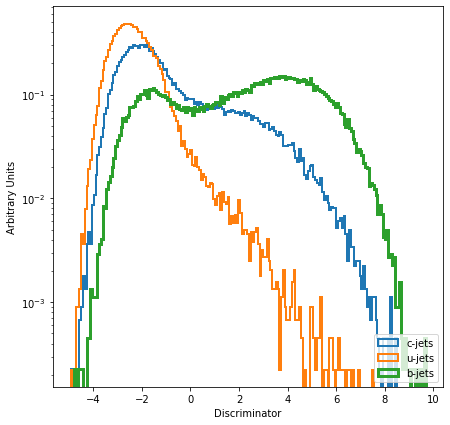

(199,) (199,) (199,)


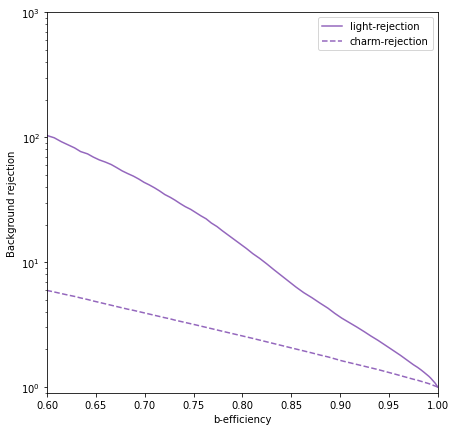

In [52]:
makeROC(preds,true_labels,"model1")

## Auxiliary tasks

TODO